In [1]:
import numpy as np
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

In [2]:
import os
os.getcwd()

'/lambda_stor/homes/ac.tfeng/git/Precily/notebook'

In [3]:
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
np.random.seed(2)

##loading 90% Training data
train_set = pd.read_csv('../Fig1/Fig1c/Fig1c_Precily_pathways/Training_data.csv')
directory = 'Path to directory'
project_name = 'Pathways'



In [4]:
train_set

,0,1,2,3,4,5,6,7,8,9,...,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431
0,5637,5-Fluorouracil,0.053079,0.165540,0.091635,0.227477,0.017556,0.028403,0.170392,-0.202645,...,-0.011703,-0.414060,0.061474,0.549070,-0.192303,0.185672,-0.128457,0.024697,0.263466,3.313258
1,5637,ABT737,0.053079,0.165540,0.091635,0.227477,0.017556,0.028403,0.170392,-0.202645,...,-0.113681,0.204337,-0.150768,0.114594,-0.110021,0.197329,-0.206644,-0.351558,0.035348,2.631881
2,5637,Acetalax,0.053079,0.165540,0.091635,0.227477,0.017556,0.028403,0.170392,-0.202645,...,0.079674,0.481107,-0.289358,0.153831,-0.011794,0.442237,-0.127095,-0.152633,0.010294,6.639999
3,5637,Afatinib,0.053079,0.165540,0.091635,0.227477,0.017556,0.028403,0.170392,-0.202645,...,-0.019880,0.096177,0.073550,0.238451,-0.160336,0.069875,-0.041842,-0.101994,0.249072,-0.036451
4,5637,Afuresertib,0.053079,0.165540,0.091635,0.227477,0.017556,0.028403,0.170392,-0.202645,...,-0.151985,0.201704,-0.057129,0.264910,-0.087108,0.127217,-0.096696,-0.103081,0.269846,4.244100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72257,ZR7530,WZ4003,-0.208306,-0.435273,-0.183318,0.285707,0.172914,-0.375183,0.453495,0.134856,...,-0.089557,0.165352,0.108666,0.303081,-0.134477,-0.033886,-0.265216,-0.183178,0.201950,5.864494
72258,ZR7530,XAV939,-0.208306,-0.435273,-0.183318,0.285707,0.172914,-0.375183,0.453495,0.134856,...,0.129878,0.120458,-0.748445,0.263994,-0.248687,0.403244,0.154301,-0.176284,0.412317,5.534174
72259,ZR7530,YK-4-279,-0.208306,-0.435273,-0.183318,0.285707,0.172914,-0.375183,0.453495,0.134856,...,-0.159893,0.073494,-0.149774,0.351966,0.004359,0.568684,0.007246,-0.031883,0.455600,6.484139
72260,ZR7530,ZM447439,-0.208306,-0.435273,-0.183318,0.285707,0.172914,-0.375183,0.453495,0.134856,...,0.164281,0.307866,-0.026162,0.069261,0.002608,0.161844,-0.133051,-0.091529,0.232594,4.432672


In [5]:
##Definining hyper parameters
layers_range = (2, 6)
units_range = (128, 256, 4)
lr_values = [1e-3, 1e-4, 1e-5]


##Define model
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(1429, input_dim=1429, activation="relu"))
    model.add(keras.layers.Dense(units=512, activation="relu"))
    model.add(
        keras.layers.Dropout(
            hp.Float("dropout", min_value=0.1, max_value=0.5, default=0.1, step=0.1)
        )
    )

    for i in range(hp.Int("layers", layers_range[0], layers_range[1])):
        model.add(
            keras.layers.Dense(
                units=hp.Int(
                    "units_" + str(i),
                    min_value=units_range[0],
                    max_value=units_range[1],
                    step=units_range[2],
                ),
                activation="relu",
            )
        )
        model.add(
            keras.layers.Dropout(
                hp.Float("dropout", min_value=0.1, max_value=0.5, default=0.1, step=0.1)
            )
        )

        model.add(keras.layers.Dense(1))
    hp_learning_rate = hp.Choice("learning_rate", values=lr_values)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="mean_squared_error",
    )
    return model

In [6]:
CL_x = train_set[train_set.columns[0]].unique()
CL_x = list(CL_x)

##Perform hyperparameter tuning
for i in range(1):
    A = set(CL_x[: i * len(CL_x) // 5] + CL_x[(i + 1) * len(CL_x) // 5 :])
    B = set(CL_x[i * len(CL_x) // 5 : (i + 1) * len(CL_x) // 5])

    train, val = [], []
    for j in train_set.to_numpy():
        if j[0] in A:
            train.append(j)
        else:
            val.append(j)

    train = pd.DataFrame(train)
    val = pd.DataFrame(val)
    # train.to_csv(path+"Train_Set_"+str(i+1)+".csv",index=False)
    # val.to_csv(path+"Validation_Set_"+str(i+1)+".csv",index=False)
    X_train = train.iloc[:, 2:-1]
    Y_train = train.iloc[:, -1:]
    X_val = val.iloc[:, 2:-1]
    Y_val = val.iloc[:, -1:]
    train, test = None, None
    X_train.to_csv("Train_Set_" + str(i + 1) + ".csv", index=False)
    Y_train.to_csv("Train_Set_truth_" + str(i + 1) + ".csv", index=False)
    X_val.to_csv("Val_Set_" + str(i + 1) + ".csv", index=False)
    Y_val.to_csv("Val_Set_truth_" + str(i + 1) + ".csv", index=False)

    tuner = kt.Hyperband(
        model_builder,  # the hypermodel
        objective="val_loss",  # objective to optimize
        max_epochs=30,
        factor=3,
        directory=directory,  # directory to save logs
        project_name=project_name + str(i + 1),
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
    tuner.search(
        X_train,
        Y_train,
        epochs=30,
        validation_data=(X_val, Y_val),
        callbacks=[stop_early],
    )
    best_hp = tuner.get_best_hyperparameters()[0]
    best_model = tuner.get_best_models()[0]

    # Build the model with the optimal hyperparameters
    h_model = tuner.hypermodel.build(best_hp)
    h_model.fit(
        X_train,
        Y_train,
        epochs=50,
        verbose=1,
        batch_size=128,
        validation_data=(X_val, Y_val),
    )
    h_model.save("precily_cv_" + str(i + 1) + ".hdf5")
    h_model = None

INFO:tensorflow:Reloading Tuner from Path to directory/Pathways1/tuner0.json
INFO:tensorflow:Oracle triggered exit


2023-07-27 08:39:13.254042: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-27 08:39:13.254288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 08:39:14.418598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-27 08:39:14.422496: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


Epoch 1/50
 39/450 [=>............................] - ETA: 16s - loss: 13.8766

In [3]:
best_hp = tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
csv_logger = tf.keras.callbacks.CSVLogger('training.log')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

h_model.fit(
    X_train,
    Y_train,
    epochs=50,
    verbose=1,
    batch_size=128,
    validation_data=(X_val, Y_val),
    callbacks = [stop_early, tensorboard_callback, csv_logger]
)

NameError: name 'tuner' is not defined

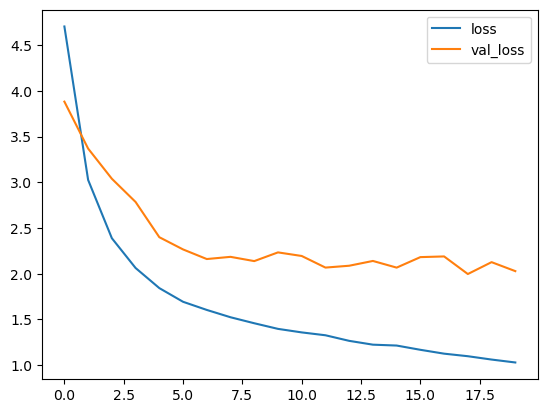

In [20]:
import matplotlib.pyplot as plt


training_log = pd.read_csv("training.log")
plt.plot(training_log.epoch, training_log.loss, label='loss')
plt.plot(training_log.epoch, training_log.val_loss, label = 'val_loss')
plt.legend()
# training_log.plot.line(x='epoch', y='val_loss')

## Testing

In [21]:
test_set = pd.read_csv('../Fig1/Fig1c/Fig1c_Precily_pathways/Test_Set.csv')
test_set


,0,1,2,3,4,5,6,7,8,9,...,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431
0,22RV1,5-Fluorouracil,-0.033926,0.618440,-0.123854,0.421681,0.025471,-0.154110,0.495994,0.278725,...,-0.011703,-0.414060,0.061474,0.549070,-0.192303,0.185672,-0.128457,0.024697,0.263466,2.478859
1,22RV1,ABT737,-0.033926,0.618440,-0.123854,0.421681,0.025471,-0.154110,0.495994,0.278725,...,-0.113681,0.204337,-0.150768,0.114594,-0.110021,0.197329,-0.206644,-0.351558,0.035348,3.748055
2,22RV1,Acetalax,-0.033926,0.618440,-0.123854,0.421681,0.025471,-0.154110,0.495994,0.278725,...,0.079674,0.481107,-0.289358,0.153831,-0.011794,0.442237,-0.127095,-0.152633,0.010294,-0.933771
3,22RV1,Afatinib,-0.033926,0.618440,-0.123854,0.421681,0.025471,-0.154110,0.495994,0.278725,...,-0.019880,0.096177,0.073550,0.238451,-0.160336,0.069875,-0.041842,-0.101994,0.249072,2.433064
4,22RV1,Afuresertib,-0.033926,0.618440,-0.123854,0.421681,0.025471,-0.154110,0.495994,0.278725,...,-0.151985,0.201704,-0.057129,0.264910,-0.087108,0.127217,-0.096696,-0.103081,0.269846,1.463836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7789,UACC62,Wnt-C59,0.209341,0.400814,0.066794,0.121703,0.119831,0.461503,-0.123105,-0.001658,...,-0.067829,0.241042,-0.183206,0.194232,-0.125074,0.113843,-0.077665,-0.176095,-0.088392,3.546547
7790,UACC62,WZ4003,0.209341,0.400814,0.066794,0.121703,0.119831,0.461503,-0.123105,-0.001658,...,-0.089557,0.165352,0.108666,0.303081,-0.134477,-0.033886,-0.265216,-0.183178,0.201950,2.297718
7791,UACC62,XAV939,0.209341,0.400814,0.066794,0.121703,0.119831,0.461503,-0.123105,-0.001658,...,0.129878,0.120458,-0.748445,0.263994,-0.248687,0.403244,0.154301,-0.176284,0.412317,5.473609
7792,UACC62,YK-4-279,0.209341,0.400814,0.066794,0.121703,0.119831,0.461503,-0.123105,-0.001658,...,-0.159893,0.073494,-0.149774,0.351966,0.004359,0.568684,0.007246,-0.031883,0.455600,3.071966


In [23]:
X_test = test_set.iloc[:,2:-1]
Y_test = test_set.iloc[:,-1:]